In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
import rdflib
from lxml import etree
import pandas
import re
import xml.etree.ElementTree as ET
import os

# c) General
import copy
import difflib
import numpy as np


# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams

In [2]:
# Ontologies:
# Save the .csv files of the required ontology from https://bioportal.bioontology.org/ontologies
OPB = pandas.read_csv('OPB.csv')

# Extraction of IDs & Labels in the ontologies (here, we just neeed the OPB ontology)

opbID = OPB['Class ID']
opbLabel= OPB['Preferred Label']

In [3]:
## Asking for the type & location of the model given to the function: 

# Output(s): a) List of the categories in which each CellML model fits.
#            b) List of the addresses of the CellML files
def catRecognition():
    
    print('Please select the category of the models according to the following list:')
    
    print('\n')
    print('MAPK ==> insert "m"')
    print('\n')
    print('\n')
    print('Antenna drive system ==> insert "a"')
    
    
    cat=[]
    add=[]


    e='Invalid Input'
    while True:
        try:
            c=input('Enter the category of the model : ')
#             c=difflib.get_close_matches(c, ['m'])
            cat.append(c)

            add.append(input('Enter the location address for the corresponding file : '))

            more=input('More files?(Y/N)')
            if more.lower() != 'y':
                break

        except Exception as e:
            print(e)
            
    return[cat,add]

In [6]:
# Here, the category of each model(system) is asked along with the file location. Enter the location of the cellml file 
# similar to the one below:
# /Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/motor.cellml
# /Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/rotor.cellml
# /Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/load.cellml
# Make sure you don't put the addresses in quotation marks
# [categories,addresses]=catRecognition()

In [7]:
# Run this cell if you don't want to run the catRecognition() and add the files manually.
categories=['a', 'a', 'a'];
addresses=['/Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/rotor.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/motor.cellml',
 '/Users/nsha457/Documents/Jupyter_files/Annot_Merging/DC motor/load.cellml']

In [8]:
## Extracting the data (annotations & values) from the CellML files

#  Input(s):    add: The list of locations (addresses) which is the output from the "catRecognition" function

#  Output(s):   a) List: a dictionary containing the names of the variables in the CellML files (in the order of the 
#                        found annotations)
#               b) annotations: a dictionary containing the annotations in the CellML files
#               c) root: a dictionary containing the imported XML data from the CellML files

def getAnnotations(add):
    parser = etree.XMLParser(recover=True)
    root = etree.parse(add, parser).getroot()
    rdfGraph = rdflib.Graph()
    for rdfElement in root.iter():
        if rdfElement.tag.endswith('RDF'):
            try:
                rdfGraph.parse(data = etree.tostring(rdfElement))
            except:
                pass
            
    def getLeaves(sbj, graph):
        triples = list(graph.triples((sbj,None,None)))
        leaves = []
        if len(triples)>0:
            for s, p, o in triples:
                result =  getLeaves(o,graph)
                leaves += result
            return list(set(leaves))
        else:
            return [sbj]
        
    # Opens the CellML file and returns the list of variables names
    base=os.path.basename(add)
    f = open(base,'r')
    text = f.read()
    root = ET.fromstring(text)

    rdfs = root.findall('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF')

    List1=[]
    for child in rdfs:
        for grand in child:
            List1.append(grand.attrib.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}about'))
    
    List = list(dict.fromkeys(List1))
    List.remove('#metaid0')


    triplesList={}
    for i in range(len(List)):
        sbj = rdflib.URIRef(List[i])
        triplesList[i]=getLeaves(sbj, rdfGraph)

        # In this part we match the number found in the rdf of the CellML file 
        # with the ones found in the "Class IDs" and "Preferred Labels"

    annotations1={}

    for i in range(len(triplesList)):
        annotations1[i]=[]
        for k in range(len(triplesList[i])):
            l=triplesList[i][k]
            if 'opb' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for OPB
                for j in range(len(opbID)):
                    numID=re.findall(r'\d+', opbID[j])
                    if numCell == numID:
                        annotations1[i].append(opbLabel[j])
            elif 'chebi' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for CHEBI
                for j in range(len(chebiID)):
                    numID=re.findall(r'\d+', chebiID[j])
                    if numCell == numID:
                        annotations1[i].append(chebiLabel[j])
            elif 'fma' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for FMA
                for j in range(len(fmaID)):
                    numID=re.findall(r'\d+', fmaID[j])
                    if numCell == numID:
                        annotations1[i].append(fmaLabel[j])

            elif 'go' in l: 
                numCell= re.findall(r'\d+', l) # This will find any number in the string for GO
                for j in range(len(goID)):
                    numID=re.findall(r'\d+', goID[j])
                    if numCell == numID:
                        annotations1[i].append(goLabel[j])

            elif 'input' in l.lower(): # 'input' is a free-style description!
                annotations1[i].append('input') # So we look for it separately.
                
            elif 'gyrator' in l.lower(): # 'gyrator' is a free-style description!
                annotations1[i].append('gyrator') # So we look for it separately.
                
            elif 'motor' in l.lower(): # 'motor' is a free-style description!
                annotations1[i].append('motor') # So we look for it separately.
                
            elif 'rotor' in l.lower(): # 'rotor' is a free-style description!
                annotations1[i].append('rotor') # So we look for it separately.
                
            elif 'transformer' in l.lower(): # 'transformer' is a free-style description!
                annotations1[i].append('transformer') # So we look for it separately.
                
            elif 'load' in l.lower(): # 'load' is a free-style description!
                annotations1[i].append('load') # So we look for it separately.


    for i in range(len(annotations1)):
        annotations1[i]=[x.lower() for x in annotations1[i]] 

    annotations = {}; k=0;

    for key,value in annotations1.items():
        if value not in annotations.values():
            annotations[k] = value
            k+=1

    return [List,annotations,root]

In [9]:
## Extracting values from the CellML files

#  Input(s):  root: a dictionary containing the imported XML data from the output of the "getAnnotations" functions

#  Output(s): els: (representing the elements) a dictionary containing the names of the variables in the CellML files 
#                  (in the order of the  found initial amounts)
#             init: (representing the initials) a dictionary containing the initial amounts of the variables in the 
#                   CellML files 

def valExtraction(root): 
    
    variables=[]; els=[]; init=[];

    components = root.findall('{http://www.cellml.org/cellml/1.1#}component')


    for comp in components:
        variables.append(comp.findall('{http://www.cellml.org/cellml/1.1#}variable'))


    for var in variables:
        for v in var:   #Here search for the variable names(els) and their initial amounts(init)
            els.append(v.attrib['{http://www.cellml.org/metadata/1.0#}id'])   

            if 'initial_value' in v.attrib: # if any initial value exists take it
                init.append(v.attrib['initial_value'])    
            else:
                init.append(None)
    return[els,init]

In [10]:
# In the following script the two above functions (getAnnotations,valExtraction) are used to extract the annotations,
# variable names, and amounts. For instance, all the annotations of all the files will be saved in ONE
# dictionary (annotationsMAPKunsorted) as annotationsMAPKunsorted={'0':{...,...,...}, '1':{...,...,...}, ...}
listMAPK={}; annotationsMAPKunsorted={}; rootMAPK={}; elementsMAPK={}; initialsMAPK={}; 

listAntenna={}; annotationsAntennaUnsorted={}; rootAntenna={}; elementsAntenna={}; initialsAntenna={};
for i in range(len(categories)):
    if categories[i][0] == 'm':
        [listMAPK[str(i)],annotationsMAPKunsorted[str(i)],rootMAPK[str(i)]]=getAnnotations(addresses[i])        
        [elementsMAPK[str(i)],initialsMAPK[str(i)]]=valExtraction(rootMAPK[str(i)])
                
    elif categories[i][0] == 'a':
        [listAntenna[str(i)],annotationsAntennaUnsorted[str(i)],rootAntenna[str(i)]]=getAnnotations(addresses[i])        
        [elementsAntenna[str(i)],initialsAntenna[str(i)]]=valExtraction(rootAntenna[str(i)])
        

In [11]:
model=bgt.new(name='Your New Model')

In [12]:
def modelMaker(Model,annotations): 

    refAnnots={'motor':{0: ['electrical resistance', 'input'], # RFmotor
            1: ['electrical resistance', 'motor'], # Rmotor                
            2: ['electrical inductance', 'motor'], # Imotor
            3: ['constitutive transformer ratio', 'gyrator'] },   # GY
               
               'rotor':{0: ['solid viscous resistance', 'rotor'], # Rrotor
            1: ['rotor', 'mass of solid entity'], # Irotor                
            2: ['solid elastance', 'rotor'], # Crotor
            3: ['constitutive transformer ratio', 'transformer'], # TF
            4: ['gyrator', 'constitutive transformer ratio'],  # GY
            5: ['mechanical displacement', 'rotor']},   # q
                
               'load':{0: ['solid viscous resistance', 'load'], # Rload
            1: ['load', 'mass of solid entity'],   # Iload
            2: ['constitutive transformer ratio', 'transformer']}}  #TF
    
    # Counting the number of unique entities in each file to detect the part of the system
    # zero_test is just for making each module work separately.

    RFmotor={}; Rmotor={}; Imotor={}; GY={}; zero_input={}; one_motor={}; zero_test_GY_motor={}; # Motor
    Rrotor={}; Irotor={}; Crotor={}; TF={}; GY={}; one_rotor={}; zero_rotor={}; zero_test_GY_rotor={}; zero_test_TF_rotor={}; # Rotor
    Rload={}; Iload={}; one_load={}; TF={}; zero_test_TF_load={}; # Load
    
    # Finding the part which each input file corresponds to:
    
    part={}
    for a in range(len(annotations)):
        motor_found=0; rotor_found=0; load_found=0; 
        
        for aa in range(len(annotations[str(a)])): 
            if 'motor' in annotations[str(a)][aa]:  # Motor
                motor_found+=1
            elif 'rotor' in annotations[str(a)][aa]: # Rotor
                rotor_found+=1
            elif 'load' in annotations[str(a)][aa]: # Load
                load_found+=1
                
        if motor_found != 0 : # It's Motor
            part[str(a)]=[]
            part[str(a)].append(list(refAnnots.keys()).index('motor')); # The index of the file that is the Motor
        elif rotor_found != 0 :
            part[str(a)]=[]
            part[str(a)].append(list(refAnnots.keys()).index('rotor')); # The index of the file that is the Rotor
        elif load_found != 0 :
            part[str(a)]=[]
            part[str(a)].append(list(refAnnots.keys()).index('load')); # The index of the file that is the Load
            
            
    newAnnot={}
    for key,value,partk,partv in zip(annotations.keys(),annotations.values(),part.keys(),part.values()):
        if key==partk: 
            newAnnot[str(partv[0])]=copy.deepcopy(value)
    
    # Dictionaries containing the generated BG components & the mergeable ones in each module
    Components={}; connectivityComps={}; mergeableComponents={};
    
    for a in newAnnot.keys(): 
        if int(a) == list(refAnnots.keys()).index('motor'):
            RFmotor[int(a)] = bgt.new("R", name=set(list(refAnnots.values())[int(a)][0])) 
            Rmotor[int(a)] = bgt.new("R", name=set(list(refAnnots.values())[int(a)][1])) 
            Imotor[int(a)] = bgt.new("I", name=set(list(refAnnots.values())[int(a)][2])) 
            GY[int(a)] = bgt.new("GY", name=set(list(refAnnots.values())[int(a)][3])) 
            zero_input[int(a)] = bgt.new("0", name='input')
            one_motor[int(a)] = bgt.new("1", name=set(list(refAnnots.values())[int(a)][1]))
            zero_test_GY_motor[int(a)] = bgt.new("0", name=set(list(refAnnots.values())[int(a)][3]))

            Components[a]={0:RFmotor[int(a)], 1:Imotor[int(a)], 2:Rmotor[int(a)], 3:one_motor[int(a)],
                                4:zero_input[int(a)], 5:GY[int(a)], 6:zero_test_GY_motor[int(a)]}
            connectivityComps[a]={0:RFmotor[int(a)], 1:Imotor[int(a)], 2:Rmotor[int(a)], 3:one_motor[int(a)],
                                4:zero_input[int(a)], 5:(GY[int(a)],0), 6:(GY[int(a)],1), 7:zero_test_GY_motor[int(a)]}
            mergeableComponents[a]={zero_input[int(a)], GY[int(a)], zero_test_GY_motor[int(a)]}

            
        elif int(a) == list(refAnnots.keys()).index('rotor'):
            Rrotor[int(a)] = bgt.new("R", name=set(list(refAnnots.values())[int(a)][0])) 
            Irotor[int(a)] = bgt.new("I", name=set(list(refAnnots.values())[int(a)][1])) 
            Crotor[int(a)] = bgt.new("C", name=set(list(refAnnots.values())[int(a)][2])) 
            TF[int(a)] = bgt.new("TF", name=set(list(refAnnots.values())[int(a)][3]))
            GY[int(a)] = bgt.new("GY", name=set(list(refAnnots.values())[int(a)][4])) 
            one_rotor[int(a)] = bgt.new("1", name=set(list(refAnnots.values())[int(a)][0]))
            zero_rotor[int(a)] = bgt.new("0", name=set(list(refAnnots.values())[int(a)][3])) 
            zero_test_GY_rotor[int(a)] = bgt.new("0", name=set(list(refAnnots.values())[int(a)][4]))
            zero_test_TF_rotor[int(a)] = bgt.new("0", name=set(list(refAnnots.values())[int(a)][3]))

            Components[a]={0:Rrotor[int(a)], 1:Irotor[int(a)], 2:Crotor[int(a)], 3:TF[int(a)], 
                           4:GY[int(a)], 5:one_rotor[int(a)], 6:zero_rotor[int(a)], 7:zero_test_GY_rotor[int(a)],
                           8:zero_test_TF_rotor[int(a)]}
            connectivityComps[a]={0:Rrotor[int(a)], 1:Irotor[int(a)], 2:Crotor[int(a)], 3:(TF[int(a)],0), 
                                 4:(TF[int(a)],1),5:(GY[int(a)],0),6:(GY[int(a)],1),7:one_rotor[int(a)],
                                  8:zero_rotor[int(a)],9:zero_test_GY_rotor[int(a)], 10:zero_test_TF_rotor[int(a)]}
            mergeableComponents[a]={GY[int(a)], zero_test_GY_rotor[int(a)], TF[int(a)], zero_test_TF_rotor[int(a)]}
            

            
        elif int(a) == list(refAnnots.keys()).index('load'):
            Rload[int(a)] = bgt.new("R", name=set(list(refAnnots.values())[int(a)][0])) 
            Iload[int(a)] = bgt.new("I", name=set(list(refAnnots.values())[int(a)][1]))
            TF[int(a)] = bgt.new("TF", name=set(list(refAnnots.values())[int(a)][2]))
            one_load[int(a)] = bgt.new("1", name=set(list(refAnnots.values())[int(a)][0]))
            zero_test_TF_load[int(a)] = bgt.new("0", name=set(list(refAnnots.values())[int(a)][2]))
            
            Components[a]={0:Rload[int(a)], 1:Iload[int(a)], 2:TF[int(a)], 3:one_load[int(a)],4:zero_test_TF_load[int(a)]}
            connectivityComps[a]={0:Rload[int(a)],1:Iload[int(a)],2:(TF[int(a)],0),3:(TF[int(a)],1), 4:one_load[int(a)],
                                  5:zero_test_TF_load[int(a)]}
            mergeableComponents[a]={TF[int(a)], zero_test_TF_load[int(a)]};
            
    
     # Connectivity Matrix for each part
    connectivityMatrixMotor=np.zeros((8,8))
    connectivityMatrixMotor[3][1]=1; connectivityMatrixMotor[3][2]=1; connectivityMatrixMotor[3][7]=1;
    connectivityMatrixMotor[4][0]=1; connectivityMatrixMotor[4][3]=1; connectivityMatrixMotor[7][5]=1; 
    
    connectivityMatrixMotorr=[] # Converting the connectivityMatrix from array to list
    for i in range(len(connectivityMatrixMotor)):
        connectivityMatrixMotorr.append(list(connectivityMatrixMotor[i]))     

    
    connectivityMatrixRotor=np.zeros((11,11))
    connectivityMatrixRotor[6][9]=1; connectivityMatrixRotor[7][0]=1; connectivityMatrixRotor[7][1]=1; 
    connectivityMatrixRotor[7][8]=1; connectivityMatrixRotor[8][2]=1; connectivityMatrixRotor[8][10]=1; 
    connectivityMatrixRotor[9][7]=1; connectivityMatrixRotor[10][3]=1; 
    
    connectivityMatrixRotorr=[] # Converting the connectivityMatrix from array to list
    for i in range(len(connectivityMatrixRotor)):
        connectivityMatrixRotorr.append(list(connectivityMatrixRotor[i]))   
    
    
    connectivityMatrixLoad=np.zeros((6,6))
    connectivityMatrixLoad[3][5]=1; connectivityMatrixLoad[4][0]=1; connectivityMatrixLoad[4][1]=1; 
    connectivityMatrixLoad[5][4]=1; 
    
    connectivityMatrixLoadd=[] # Converting the connectivityMatrix from array to list
    for i in range(len(connectivityMatrixLoad)):
        connectivityMatrixLoadd.append(list(connectivityMatrixLoad[i])) 
    
    initialCMs={}
    for a in Components.keys():
        if int(a) == list(refAnnots.keys()).index('motor'):
            initialCMs[a] = copy.deepcopy(connectivityMatrixMotorr)
        if int(a) == list(refAnnots.keys()).index('rotor'):
            initialCMs[a] = copy.deepcopy(connectivityMatrixRotorr)
        if int(a) == list(refAnnots.keys()).index('load'):
            initialCMs[a] = copy.deepcopy(connectivityMatrixLoadd)
    
    return [refAnnots,initialCMs,mergeableComponents,Components,connectivityComps,newAnnot]
            
##### Note: The concept of common components in biology is not usually found in electrical or mechanical systems.
#####       Two systems can have exactly the same resistors (in terms of value & name) but still they are not mergeable!
#####       Thus, we have separated them by adding additional annotations referring to the name of their module i.e. 
#####       "motor", "rotor", "load"
#####       So, mergeable components here would be junctions, Gyrators, and transformers common between the modules
#####       How to check for mutual components now? We have similarlly annotated the mergeable components,
####        and they are present in both the modules which are supposed to be coupled.

In [13]:
[refAnnots,initialCMs,mergeableComponents,Components,connectivityComps,newAnnot]=modelMaker(model,annotationsAntennaUnsorted)

In [14]:
def checkMutual(category,annotations,List,els,init): 
    
    if len(category)>1: # if more than one reaction is added, there's a probability of mutual annotations
        commonAnnots={}; # common annotations will be saved in pairs of modules (k1,k2)
        CommonAmountsA={};  # First element of the pair (firstModule,secondModule) stored in this dictionary
        CommonAmountsB={};  # Second element of the pair (firstModule,secondModule) stored in this dictionary
        
        modelsNumber = len(annotations)  # The number of the input files (models)
        k=-1; kk=0
        for i,a in zip(range(modelsNumber),annotations.keys()):
            kk+=1; ii=0;
            
            while ii+kk < modelsNumber:  # Finding common anotations between each pair of the modules
                commonAnnots[a,list(annotations.keys())[ii+kk]]=[]
                k+=1
                CommonAmountsA[str(k)]=[]; CommonAmountsB[str(k)]=[]
                for a1 in range(len(list(annotations.values())[i])):
                    for a2 in range(len(list(annotations.values())[ii+kk])):
# mergeables ...        
                        if set(list(annotations.values())[i][a1]) == set(list(annotations.values())[ii+kk][a2]) and list(annotations.values())[i][a1] !=[]:
                            commonAnnots[list(annotations.keys())[i],list(annotations.keys())[ii+kk]].append(list(annotations.values())[i][a1]) 
                            varIDA=List[str(i)][a1].strip('#')
                            for e in range(len(els[str(i)])):
                                if varIDA == els[str(i)][e].strip('#'):
                                    
                                    CommonAmountsA[str(k)].append(init[str(i)][e])

                            varIDB=List[str(ii+kk)][a2].strip('#')
                            for e in range(len(els[str(ii+kk)])):
                                if varIDB == els[str(ii+kk)][e]:
                                    CommonAmountsB[str(k)].append(init[str(ii+kk)][e])  
                ii+=1
                                           
            
    # Finding the variables with the same annotations and different values & ignoring the ones with same values    
    commonAnnotsDiffVals={}; CommonAmountsAA={}; CommonAmountsBB={};
    for k in range(len(list(commonAnnots.keys()))):
        commonAnnotsDiffVals[list(commonAnnots.keys())[k]]=[]
        CommonAmountsAA[list(commonAnnots.keys())[k]]=[]
        CommonAmountsBB[list(commonAnnots.keys())[k]]=[]
        for v in range(len(list(commonAnnots.values())[k])):
            if list(CommonAmountsA.values())[k][v] != list(CommonAmountsB.values())[k][v]:
                commonAnnotsDiffVals[list(commonAnnots.keys())[k]].append(list(commonAnnots.values())[k][v])
                CommonAmountsAA[list(commonAnnots.keys())[k]].append(list(CommonAmountsA.values())[k][v])
                CommonAmountsBB[list(commonAnnots.keys())[k]].append(list(CommonAmountsB.values())[k][v])
                                  
    
    # Getting the preferred value from the user for the recognised same variables with different values
    for i in range(len(list(commonAnnotsDiffVals.keys()))):
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):
            print('Different values found for: ')
            print('\n')
            print(list(commonAnnotsDiffVals.values())[i][j] ,list(commonAnnotsDiffVals.keys())[i],':',list(CommonAmountsAA.values())[i][j],  'and' , list(CommonAmountsBB.values())[i][j])   
            list(CommonAmountsAA.values())[i][j]=copy.deepcopy(input('Enter the preferred value:'))
               
                
    # Copying the changed values to the list of initial amounts of the model    
    for i in range(len(list(commonAnnotsDiffVals.keys()))): # number of pairs of models 
        for j in range(len(list(commonAnnotsDiffVals.values())[i])):   
            for n,k in zip(range(len(annotations)),annotations.keys()): 
                for f in range(len(list(annotations[k].values()))):
                    if set(list(commonAnnotsDiffVals.values())[i][j]) == set(list(annotations[k].values())[f]):
                        varID=List[str(n)][f].strip('#')
                        for r in range(len(els[str(n)])):
                            if varID == els[str(n)][r].strip('#'): # Assigning the new values to the old ones in all the models
                                init[str(n)][r]=copy.deepcopy( list(CommonAmountsAA.values())[i][j]) 

                        
                  
    return[commonAnnots, init]

In [15]:
[commonAnnots,initialsAntenna]=checkMutual(categories,newAnnot,listAntenna,elementsAntenna,initialsAntenna)        

Different values found for: 


['gyrator', 'constitutive transformer ratio'] ('1', '0') : 1 and 10
Enter the preferred value:1
Different values found for: 


['transformer', 'constitutive transformer ratio'] ('1', '2') : 1 and 100
Enter the preferred value:1


In [16]:
def componentConnectivityMatrixRemove(commonAnnots,mergeableComponents,Components,connectivityComps,initialCMs,model):

    modelNum_commonCompRemove=[]; # List of common components between the models along with their corresponding model number
    modelNum_connectivityCompsRemove=[];
    for k in commonAnnots.keys(): # check if the common annotations found, are among the mergeable components?
        for v in commonAnnots[k]: 
            for kk in mergeableComponents.keys():
                for i in range(0,2):                
                    if k[i] == kk: 
                        for vv in mergeableComponents[kk]:
                            if set(v) == set(vv.name) and vv.metamodel != '0' and  vv.metamodel != '1': # if YES, find the corresponding component
                                modelNum_commonCompRemove.append(int(kk)) # model number for recognizing that each component belongs to which model
                                modelNum_commonCompRemove.append(vv)                             
                        break 
            for c in connectivityComps.keys():
                for i in range(0,2): 
                    if k[i] == c:
                        for cc in connectivityComps[c]:
                            if type(connectivityComps[c][cc]) is tuple and set(v) == set(connectivityComps[c][cc][0].name):
                                #or (type(connectivityComps[c][cc]) is not tuple and set(v) == set(connectivityComps[c][cc].name)):
                                modelNum_connectivityCompsRemove.append(int(c))
                                modelNum_connectivityCompsRemove.append(connectivityComps[c][cc]) 
                        break
    # if we have found (n) common components in (n) models, we need to remove (n-1) of them   
    # Keeping one component from each set of mutual components in "jointComps"
    check=[]; length=len(modelNum_commonCompRemove); i=1; jointComps=[];
    while i<length:  #For removing the extra components from "Components"

        if modelNum_commonCompRemove[i].name not in check:
            check.append(set(modelNum_commonCompRemove[i].name) )
#             jointComps.append(modelNum_commonCompRemove[i-1])
#             jointComps.append(modelNum_commonCompRemove[i])
            modelNum_commonCompRemove.pop(i)
            modelNum_commonCompRemove.pop(i-1)
#         else:
#             modelNum_commonCompRemove.pop(i)
#             modelNum_commonCompRemove.pop(i-1)

        length = len(modelNum_commonCompRemove)        
        i+=2
        
    check=[]; length=len(modelNum_connectivityCompsRemove); i=1; jointConnect=[];
    while i<length:#For removing the extra components from "connectivityComps" to later modify the "connectivityBondsRow"
        
        if type(modelNum_connectivityCompsRemove[i]) is not tuple:
            if modelNum_connectivityCompsRemove[i].name not in check:
                check.append(set(modelNum_connectivityCompsRemove[i].name) )
                jointConnect.append(modelNum_connectivityCompsRemove[i-1])
                jointConnect.append(modelNum_connectivityCompsRemove[i])
                modelNum_connectivityCompsRemove.pop(i)
                modelNum_connectivityCompsRemove.pop(i-1)
            else:
                modelNum_connectivityCompsRemove.pop(i)
                modelNum_connectivityCompsRemove.pop(i-1)
            length = len(modelNum_connectivityCompsRemove)        
            i+=2
        else:
            if modelNum_connectivityCompsRemove[i][0].name not in check:
                check.append(modelNum_connectivityCompsRemove[i][0].name)
                jointConnect.append(modelNum_connectivityCompsRemove[i-1])
                jointConnect.append(modelNum_connectivityCompsRemove[i])
                jointConnect.append(modelNum_connectivityCompsRemove[i+1])
                jointConnect.append(modelNum_connectivityCompsRemove[i+2])
                modelNum_connectivityCompsRemove.pop(i+2)
                modelNum_connectivityCompsRemove.pop(i+1)
                modelNum_connectivityCompsRemove.pop(i)
                modelNum_connectivityCompsRemove.pop(i-1)

            else:
                modelNum_connectivityCompsRemove.pop(i+2)
                modelNum_connectivityCompsRemove.pop(i+1)
                modelNum_connectivityCompsRemove.pop(i)
                modelNum_connectivityCompsRemove.pop(i-1)


            length = len(modelNum_connectivityCompsRemove)        
            i+=4
    
    # If the joint component in "jointConnect" is a tuple, remove the ports which are already connected and keep 
    # the free ports
    delete=[]
    for j in range(len(jointConnect)):

        for key in connectivityComps.keys():
            if type(jointConnect[j]) is int and jointConnect[j] == int(key):
                i=-1
                for val in connectivityComps[key].values():
                    i+=1
                    if type(jointConnect[j+1]) is tuple and type(val) is tuple and \
                       set(jointConnect[j+1][0].name) == set(val[0].name) and jointConnect[j+1][1] == val[1]:

                        for k in range(len(initialCMs[str(key)])):
                            if initialCMs[str(key)][i][k]==1 or initialCMs[str(key)][k][i]==1:
                                delete.append(jointConnect[j+1])

    i=0
    length=len(jointConnect)
    while i<length:
        for d in delete:
            if type(d) is tuple and type(jointConnect[i]) is tuple and set(d[0].name)==set(jointConnect[i][0].name)\
               and d[1]==jointConnect[i][1]:
                del jointConnect[i]
                del jointConnect[i-1]

        i+=1
        length=len(jointConnect)     
    
    
    
    # Now removing the extra model-components from modelNum_commonCompRemove
    length=len(modelNum_commonCompRemove); i=0; j=0;
    while i<length-3:
        j=copy.deepcopy(i+2)
        while j<length-1:

            if modelNum_commonCompRemove[i] == modelNum_commonCompRemove[j] and\
            set(modelNum_commonCompRemove[i+1].name) == set(modelNum_commonCompRemove[j+1].name):
                modelNum_commonCompRemove.pop(j+1)
                modelNum_commonCompRemove.pop(j)
                length=len(modelNum_commonCompRemove)
            j+=2

            length=len(modelNum_commonCompRemove)
        length=len(modelNum_commonCompRemove)
        i+=2



    # We have kept 'one' component from each duplicates bundle. Now all the remaining components in the 
    # modelNum_commonCompRemove must be removed from the components
    comps=[]; models=[];
    for i in range(len(modelNum_commonCompRemove)):
        if type(modelNum_commonCompRemove[i]) == int:

            for j in range(len(Components[str(modelNum_commonCompRemove[i])])):
                if Components[str(modelNum_commonCompRemove[i])][j].metamodel!='0' and Components[str(modelNum_commonCompRemove[i])][j].metamodel!='1' and Components[str(modelNum_commonCompRemove[i])][j].name == modelNum_commonCompRemove[i+1].name :

                    models.append(modelNum_commonCompRemove[i])
                    comps.append(j)

    modelsSorted={}; check=[];
    for i in range(len(models)):
        if models[i] not in check:
            check.append(models[i])
            modelsSorted[models[i]]=[]
            modelsSorted[models[i]].append(comps[i])
        else:
            modelsSorted[models[i]].append(comps[i])


    for k in modelsSorted.keys():
        modelsSorted[k]=sorted(set(modelsSorted[k]),reverse=True)    


    for m in modelsSorted.keys():
        for k in modelsSorted[m]:
            del Components[str(m)][k]         # Deleting the duplicate components

                
    copyConnectivityCopms=copy.deepcopy(connectivityComps)
    for i in range(len(modelNum_connectivityCompsRemove)):
        if type(modelNum_connectivityCompsRemove[i]) is int:
            for key in connectivityComps.keys():
                if int(key) == modelNum_connectivityCompsRemove[i]:
                    for val in connectivityComps[key]:
                        if modelNum_connectivityCompsRemove[i+1] is connectivityComps[key][val]:
                            del connectivityComps[key][val]
                            break

 
    # Removing all the remaining components from modelNum_connectivityCompsRemove 
    comps=[]; models=[];
    for i in range(len(modelNum_connectivityCompsRemove)):
        if type(modelNum_connectivityCompsRemove[i]) == int:
            
            if type(modelNum_connectivityCompsRemove[i+1]) == tuple:
                tupleCommonCompName=modelNum_connectivityCompsRemove[i+1][0]
            else:
                tupleCommonCompName=modelNum_connectivityCompsRemove[i+1]

            for j in range(len(copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])])):
                if type(copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j]) is tuple and copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j][0].name == tupleCommonCompName.name:

                        models.append(modelNum_connectivityCompsRemove[i])
                        comps.append(j)
                        
                elif type(copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j]) is not tuple and copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j].metamodel !='0' and copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j].metamodel!='1' and copyConnectivityCopms[str(modelNum_connectivityCompsRemove[i])][j].name == tupleCommonCompName.name :

                        models.append(modelNum_connectivityCompsRemove[i])
                        comps.append(j) 
                       
    
    modelsSorted={}; check=[];
    for i in range(len(models)):
        if models[i] not in check:
            check.append(models[i])
            modelsSorted[models[i]]=[]
            modelsSorted[models[i]].append(comps[i])
        else:
            modelsSorted[models[i]].append(comps[i])


    for k in modelsSorted.keys():
        modelsSorted[k]=sorted(set(modelsSorted[k]),reverse=True)    
        
    for m in modelsSorted.keys():
        for k in modelsSorted[m]:
            for j in range(len(initialCMs[str(m)])):
                del initialCMs[str(m)][j][k]  # Removing the corresponding column in the CM 
            del initialCMs[str(m)][k]         # Deleting the corresponding row

#     Adding the components to the model
    for key in Components.keys():
        for k,v in Components[key].items():
            bgt.add(model,v)   
            
    return [jointConnect,model,Components,initialCMs,connectivityComps]

In [17]:
[jointConnect,model,Components,initialCMs,connectivityComps]=componentConnectivityMatrixRemove(commonAnnots,mergeableComponents,Components,connectivityComps,initialCMs,model)

In [18]:
def valueAllocation(annotations,refAnnots,List,els,init,Model):    
    stateVarsInitials={}  # for getting the initial amounts of the state variables. 
    for i,key in zip(range(len(annotations)),annotations.keys()): 
        for v in range(len(list(annotations[key].values()))):
            if int(key) == list(refAnnots.keys()).index('motor'):
                for k in range(0,2): 
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][k]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][k]):
                        varID=List[str(i)][v].strip('#')
                        for e in range(len(els[str(i)])):
                            if varID == els[str(i)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(refAnnots.values())[int(key)][k]) and parameter_name is ("r"):
                                        bgt.set_param(Model, param_index, float(init[str(i)][e]))
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][2]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][2]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][2]) and parameter_name is ("L"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][3]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][3]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][3]) and parameter_name is ("R"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))
                                        
            if int(key) == list(refAnnots.keys()).index('rotor'):
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][0]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][0]):
                        varID=List[str(i)][v].strip('#')
                        for e in range(len(els[str(i)])):
                            if varID == els[str(i)][e]:
                                for param_index, (component, parameter_name) in Model.params.items():
                                    if set(component.name) == set(list(refAnnots.values())[int(key)][0]) and parameter_name is ("r"):
                                        bgt.set_param(Model, param_index, float(init[str(i)][e]))  
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][1]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][1]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][1]) and parameter_name is ("L"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))         
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][2]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][2]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][2]) and parameter_name is ("C"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))  
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][3]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][3]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][3]) and parameter_name is ("r"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))  
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][4]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][4]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][4]) and parameter_name is ("R"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))                                                    
                if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][5]):  
                    varID=List[str(i)][v].strip('#')                
                    for e in range(len(els[str(i)])):
                        if varID == els[str(i)][e]:
                            stateVarsInitials[str(list(refAnnots.values())[int(key)][5])] = (float(init[str(i)][e]))

            if int(key) == list(refAnnots.keys()).index('load'):
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][0]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][0]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][0]) and parameter_name is ("r"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e]))  
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][1]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][1]):                        
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][1]) and parameter_name is ("L"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e])) 
                    if set(list(annotations[key].values())[v]) == set(list(refAnnots.values())[int(key)][2]) and len(list(annotations[key].values())[v])==len(list(refAnnots.values())[int(key)][2]):
                            varID=List[str(i)][v].strip('#')
                            for e in range(len(els[str(i)])):
                                if varID == els[str(i)][e]:
                                    for param_index, (component, parameter_name) in Model.params.items():
                                        if set(component.name) == set(list(refAnnots.values())[int(key)][2]) and parameter_name is ("r"):
                                            bgt.set_param(Model, param_index, float(init[str(i)][e])) 

                       
    return[stateVarsInitials,Model]

In [19]:
stateVarsInitials=valueAllocation(newAnnot,refAnnots,listAntenna,elementsAntenna,initialsAntenna,model)

In [20]:
def componentsListConnectivityMatrix(connectivityComps):
    connectivityBondsRow=[];

    for a in connectivityComps.keys(): 
        for i in connectivityComps[str(a)]:
            connectivityBondsRow.append(connectivityComps[str(a)][i])      
            
    return connectivityBondsRow

In [21]:
connectivityBondsRow=componentsListConnectivityMatrix(connectivityComps)

In [22]:
def connectivityWhole(initialCMs):
    
    Length=0
    for n in initialCMs.keys():
        Length+=len(initialCMs[n])
    connectivityMatrixWhole=np.zeros((Length,Length))  
    
    k=0
    for n in initialCMs.keys():
        for i in range(k,k+len(initialCMs[n])):
            for j in range(k,k+len(initialCMs[n])):
                connectivityMatrixWhole[i][j]=copy.deepcopy(initialCMs[n][i-k][j-k])
        k+=len(initialCMs[n])
        
    return connectivityMatrixWhole

In [23]:
connectivityMatrixWhole=connectivityWhole(initialCMs)

In [24]:
def addOnesModuleCompos(initialCMs,jointConnect,connectivityBondsRow,connectivityMatrixWhole):
    add={};  l1=0; l2=0; maxLimitSearch={}; check=0.1

    # Limits for searching in the indices of the connectivityBondsRow (number of components in each model)
    for m in initialCMs.keys():
        maxLimitSearch[m]=copy.deepcopy(len(initialCMs[m]))

    m=0; check=[]       
    for a in range(len(jointConnect)):     
        if type(jointConnect[a])==int:
            refModelJoint=copy.deepcopy(jointConnect[a])
        else:
            refCompJoint=copy.deepcopy(jointConnect[a])
            m=0; l1=0; l2=0;
            while m<len(maxLimitSearch):
                cycleNum=list(maxLimitSearch.keys())[m]    
                l2 += list(maxLimitSearch.values())[m]
                for i in range(l1,l2):
                    if type(refCompJoint) is tuple:
                        refCompJointName=refCompJoint[0].name  
                        refCompJointPort=refCompJoint[1]  # port to be connected in tuple
                        if type(connectivityBondsRow[i]) is tuple and refModelJoint==int(cycleNum) and set(refCompJointName) == set(connectivityBondsRow[i][0].name) and refCompJointPort==connectivityBondsRow[i][1]: 
                            refindex=copy.deepcopy(i)
                            break
                        elif type(connectivityBondsRow[i]) is not tuple and refModelJoint!=int(cycleNum) and set(refCompJointName) == set(connectivityBondsRow[i].name) and connectivityBondsRow[i].metamodel == '0':
                            # Now add a "1" for the conection found between the modules (cycles/loops)
                            connectivityMatrixWhole[refindex][i]=1
      
                    else:
                        refCompJointName=refCompJoint.name
                        
                    
                        
                    
                    
                l1 += list(maxLimitSearch.values())[m]
                m+=1
    
    
    return connectivityMatrixWhole

In [25]:
connectivityMatrixWhole=addOnesModuleCompos(initialCMs,jointConnect,connectivityBondsRow,connectivityMatrixWhole)

In [26]:
def BondsConnection(connectivityMatrixWhole,connectivityBondsRow): 

    # Creating the bonds between the components based on the elements of the connectivity matrix
    Length=len(connectivityMatrixWhole)
    bonds=[]  
    for i in range(Length):
        for j in range(Length):
            if connectivityMatrixWhole[i][j]==1:
                bonds.append((connectivityBondsRow[i],connectivityBondsRow[j]))

 
    # connecting the components for a bond graph representation of the system
    for head, tail in bonds:
        bgt.connect(head,tail)

    return model

In [27]:
model=BondsConnection(connectivityMatrixWhole,connectivityBondsRow)

In [28]:
model.state_vars

{'x_0': (I: {'rotor', 'mass of solid entity'}, 'p_0'),
 'x_1': (C: {'solid elastance', 'rotor'}, 'q_0'),
 'x_2': (I: {'motor', 'electrical inductance'}, 'p_0'),
 'x_3': (I: {'load', 'mass of solid entity'}, 'p_0')}

In [29]:
x_0={"x_0":0, "x_1":0, "x_2":1, "x_3":0}

In [30]:
Se_electric=bgt.new("Se", name='Input Voltage')  
bgt.add(model,Se_electric)
for comp in model.components:
    if type(comp) is not tuple and comp.name is 'input':
        bgt.connect(Se_electric,comp)
        break

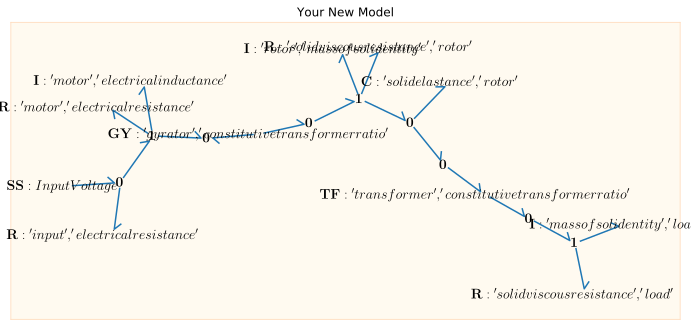

In [205]:
bgt.draw(model)

In [31]:
model.control_vars

{'u_0': (SS: Input Voltage, 'e')}

In [32]:
timespan=[0,40]
step_fn = 't < 10 ? 0 : t<25 ? 220 : 0'
t, x = bgt.simulate(model, timespan=timespan, x0=x_0, control_vars={'u_0':step_fn},  dt=0.01)

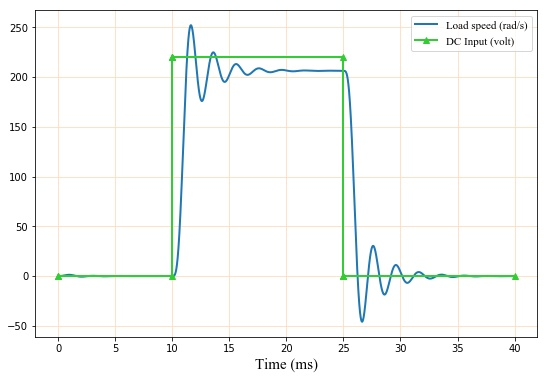

In [49]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='k')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)


plt.plot(t,-x[:,3]/0.01, linewidth='2', label='Load speed (rad/s)')
a=np.array([0,10,10.01,25,25.01,40])
b=np.array([0,0,220,220,0,0])
plt.step(a,b,'limegreen', marker='^',  linewidth='2', label='DC Input (volt)')

plt.legend(bbox_to_anchor=(1, 1), prop=font )

plt.grid(color='peachpuff')
plt.xlabel('Time (ms)', fontweight='bold',family='Times New Roman', fontsize=15)
plt.savefig('LoadSpead.jpg', dpi=300)